This is just a little example of how good or bad the data looks.

For a proper analysis, we need:
  * A proper rescaling of the electron energy scale. Right now, it's just based on the half max point.
  * A better signal model than only a Gaussian spectrum.
  * Background subtraction
  * Acceptance estimate (Current method: a guess based on how the spectra look).

### Load the spectrum from previous notebooks

In [1]:
# Load the NG data and the response function and dump output into variables
from IPython.utils import io
with io.capture_output() as output_03:
    %run '03_2d_spectra.ipynb'
with io.capture_output() as output_05:
    %run '05_response function.ipynb'

In [2]:
# You can execute one of these lines if you want to view the output of these scripts
#output_03()
#output_05()

### Define functions

In [118]:
def gaussian(x, mu, sig):
    '''
    Normalized Gaussian function
    '''
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def get_neutron_spectrum(mu, sigma):
    '''
    Get the smeared version of the response for an original neutron spectrum that is Gaussian in energy.
    Mu and sigma in MeV please.
    '''
    smeared_response = np.zeros(len(electron_energies))
    for i in range(len(neutron_energies) - 1):
        # Current neutron energy
        neutron_energy = neutron_energies[i]
        # Current bin width. Not used for now, but may be important later!
        bin_width = neutron_energies[i+1] - neutron_energies[i]
        ampl = gaussian(neutron_energy, mu, sigma)
        smeared_response += ampl*response[i]
    return smeared_response

def get_neutron_spectrum_interpolated(energy_list, a, mu, sigma):
    '''
    Interpolate the function that we get from 'get_neutron_spectrum'  to fit 'energy_list'
    '''
    smeared_response = get_neutron_spectrum(mu, sigma)
    return a * np.interp(energy_list, 1000*electron_energies, smeared_response)

def get_neutron_spectrum_interpolated_2(energy_list, a1, mu1, sigma1, a2, mu2, sigma2):
    '''
    Two copies of get_neutron_spectrum_interpolated for fitting of two energy populations
    '''
    smeared_response1 = get_neutron_spectrum(mu1, sigma1)
    smeared_response2 = get_neutron_spectrum(mu2, sigma2)
    return ( a1 * np.interp(energy_list, 1000*electron_energies, smeared_response1) +
            a2 * np.interp(energy_list, 1000*electron_energies, smeared_response2))

def get_chi_sq(y_data, y_err, y_fit):
    return sum((y_fit - y_data)**2/(y_err**2))

def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    import matplotlib as mpl
    # Arcane syntax of the week: matplotlib's Rectangle...
    plt.gca().add_patch(mpl.patches.Rectangle(
        (x[0], y[0]), x[1] - x[0], y[1] - y[0], **kwargs))


### A first trial: 'manual minimization'

In [62]:
fit_range = [450, 900]

# Selection: boolean array for the energies
sel = (x3 > fit_range[0]) & (x3 < fit_range[1])

# Select data piece to fit
x = x3[sel]
y_data = f3[sel]
y_err = np.sqrt(y_data)


best_mu = 0.
best_sigma = 0.
best_chi2 = np.inf
best_scale = 0.

# Worst minimizer routine EVER: just loop over all values :)
# Oh, and just to add to this: the scaling is just estimated based on same number of events
for mu in np.arange(2.3,2.5, 0.01):
    for sigma in np.arange(0.15,0.25,0.01):
        y_fit = get_neutron_spectrum_interpolated(x, 1., mu, sigma)
        scale_guess = sum(y_data)/sum(y_fit)
        if (get_chi_sq(y_data, y_err, scale_guess*y_fit)) < best_chi2:
            best_mu = mu
            best_sigma = sigma
            best_y_fit = scale_guess*y_fit
            best_scale = scale_guess
            best_chi2 = (get_chi_sq(y_data, y_err, scale_guess*y_fit))

print(best_mu)
print(best_sigma)

2.36
0.19


### Proper minimization

In [21]:
from iminuit import Minuit

In [83]:
class Chi2Func:
    def __init__(self,x,y,yerr):
        self.x = x
        self.y_data = y_data
        self.y_err = y_err

    def __call__(self,*arg):
        y_fit = get_neutron_spectrum_interpolated(self.x, *arg)
        chi2 = sum((self.y_data - y_fit)**2 / (self.y_err)**2)
        return chi2
    
class Chi2FuncFull:
    def __init__(self,x,y,yerr):
        self.x = x
        self.y_data = y_data
        self.y_err = y_err

    def __call__(self,*arg):
        y_fit = get_neutron_spectrum_interpolated_2(self.x, *arg)
        chi2 = sum((self.y_data - y_fit)**2 / (self.y_err)**2)
        return chi2    

In [76]:
# Select the data to fit
sel = (x3 > 450) & (x3 < 800)
x = x3[sel]
y_data = f3[sel]
y_err = np.sqrt(y_data)

# Initialize chi2 function
chi2 = Chi2Func(x, y_data, y_err)

# Give guess parameters
my_args = dict(a=300, mu=2.5, sigma=0.5, error_a = 1, error_mu = 1, error_sigma = 1)
# Initialize minimizer and minimize
m1 = Minuit(chi2,forced_parameters=['a','mu','sigma'], **my_args)
m1.migrad();
print(m1.values)

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:13: InitialParamWarning: errordef is not given. Default to 1.


FCN = 61.80951405733532 
 TOTAL NCALL = 90 
 NCALLS = 90 
 
 
 EDM = 1.1755022906125558e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a,281.13,2.25185,0,0,,,
2,mu,2.36118,0.00360517,0,0,,,
3,sigma,0.195803,0.00543806,0,0,,,


{'mu': 2.361184855009926, 'a': 281.1296346832681, 'sigma': 0.19580345428006934}


In [79]:
m2.values

{'a': 78.95094830826477, 'mu': 16.236855212044073, 'sigma': 0.4057096031429238}

In [85]:
# Select the data to fit
sel = (x3 > 450) & (x3 < 2000)
x = x3[sel]
y_data = f3[sel]
y_err = np.sqrt(y_data)

# Initialize chi2 function
chi2 = Chi2FuncFull(x, y_data, y_err)

# Give guess parameters
my_args = dict(
    a1=281, mu1=2.36, sigma1=0.196, error_a1 = 0.1, error_mu1 = 0.1, error_sigma1 = 0.01,
    a2=79, mu2=16.2, sigma2=0.4, error_a2 = 0.1, error_mu2 = 0.1, error_sigma2 = 0.1)
# Initialize minimizer and minimize
m3 = Minuit(chi2,forced_parameters=['a1','mu1','sigma1','a2','mu2','sigma2'], **my_args)
m3.migrad();
print(m3.values)

/home/erik/anaconda3/envs/pax/lib/python3.4/site-packages/ipykernel/__main__.py:15: InitialParamWarning: errordef is not given. Default to 1.


FCN = 281.90916665327194 
 TOTAL NCALL = 218 
 NCALLS = 218 
 
 
 EDM = 5.504939771119286e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,a1,271.506,1.94205,0,0,,,
2,mu1,2.35935,0.00344275,0,0,,,
3,sigma1,0.175699,0.003382,0,0,,,
4,a2,77.3757,2.97808,0,0,,,
5,mu2,16.1737,0.374558,0,0,,,
6,sigma2,0.510933,0.227404,0,0,,,


{'mu1': 2.3593532087615587, 'a2': 77.37569282821353, 'sigma2': 0.5109329447345556, 'sigma1': 0.17569872633516243, 'mu2': 16.173733590204748, 'a1': 271.50634309193435}


### Plot the result

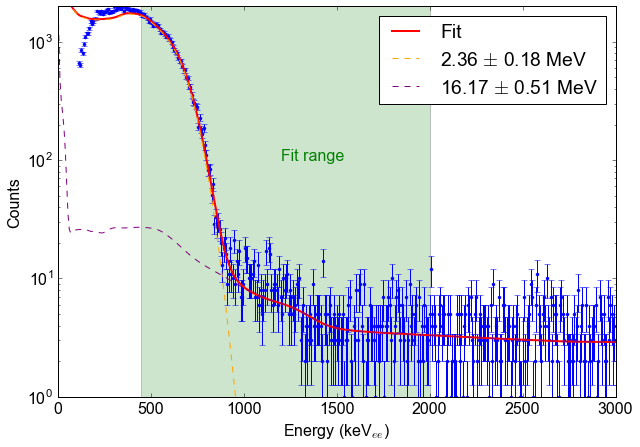

In [139]:
plt.errorbar(x3, f3, np.sqrt(f3), ls='None', marker='.')
plt.plot(x3, get_neutron_spectrum_interpolated_2(x3, **m3.values), color='red', lw=2,
        label='Fit')
plt.plot(x3, get_neutron_spectrum_interpolated(x3, m3.values['a1'], m3.values['mu1'], m3.values['sigma1'])
         , color='orange', lw=1, ls='--', 
         label='%.2f $\pm$ %.2f MeV' % (m3.values['mu1'],m3.values['sigma1']))
plt.plot(x3, get_neutron_spectrum_interpolated(x3, m3.values['a2'], m3.values['mu2'], m3.values['sigma2'])
         , color='purple', lw=1, ls='--', 
         label='%.2f $\pm$ %.2f MeV' % (m3.values['mu2'],m3.values['sigma2']))


# plt.axvline(450, color='green', ls='--')
# plt.axvline(2000, color='green', ls='--')

draw_box((450, 2000), (0, 5000), facecolor='green', alpha=0.2)
plt.text(1200, 100, 'Fit range', color='green')

plt.ylim(1,2000)
plt.xlim(0,3000)
plt.legend()
plt.yscale('log')
plt.xlabel('Energy (keV$_{ee}$)')
plt.ylabel('Counts')
plt.savefig('07_fit_spectrum.pdf', bbox_inches='tight')